In [1]:
import os
import wfdb
import pickle
import imageio
import numpy as np
import pandas as pd
import seaborn as sns
import neurokit2 as nk
import scipy.io as sci
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # For higher resolution plots
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.figsize'] = (16, 10)

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms

from tqdm import tqdm
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from scipy.signal import spectrogram, cwt, ricker

In [2]:
SAMPLING_RATE = 300 # Hz

In [3]:
basepath = "training2017"
first_rec = os.path.join(basepath, "A00001.mat")
firest_rec_header = os.path.join(basepath, "A00001")

In [4]:
ecg_signal = sci.loadmat(first_rec)["val"][0]
ecg_signal.shape

(9000,)

Text(0.5, 1.0, 'ECG Signal example')

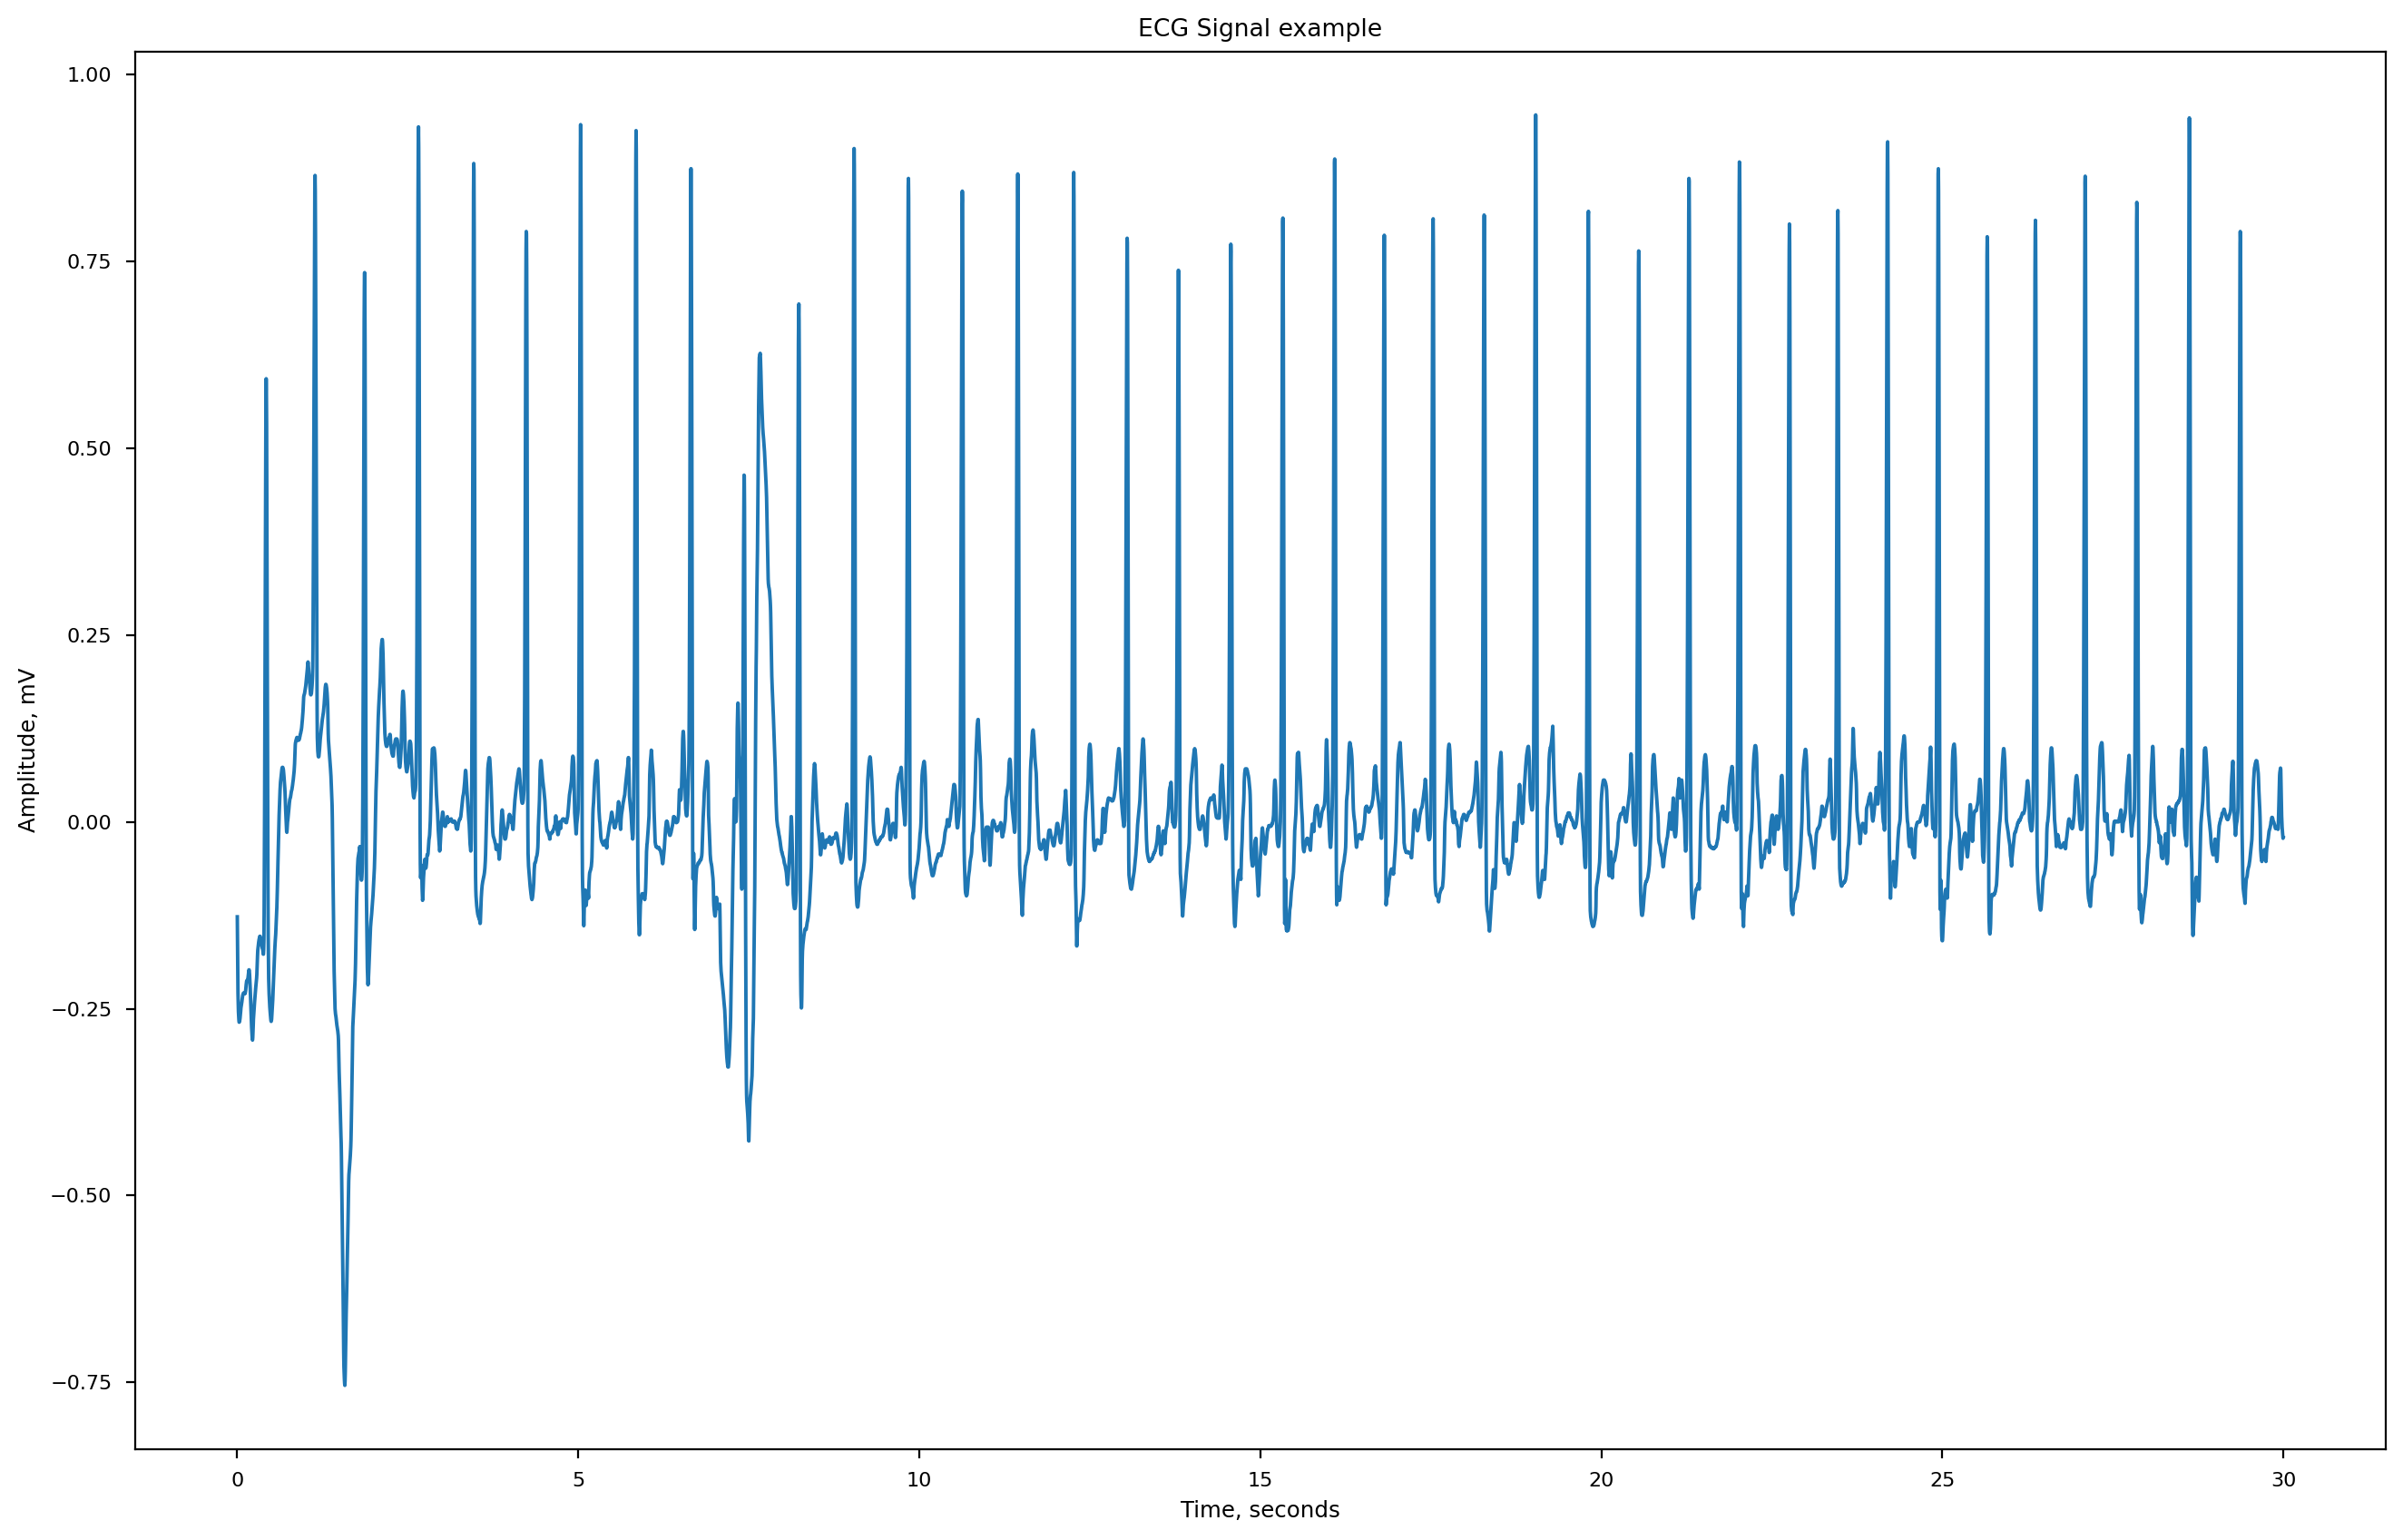

In [5]:
plt.figure(figsize=(16, 10))
plt.plot(np.arange(ecg_signal.shape[0]) / SAMPLING_RATE, ecg_signal / 1000)
plt.xlabel("Time, seconds")
plt.ylabel("Amplitude, mV")
plt.title("ECG Signal example")

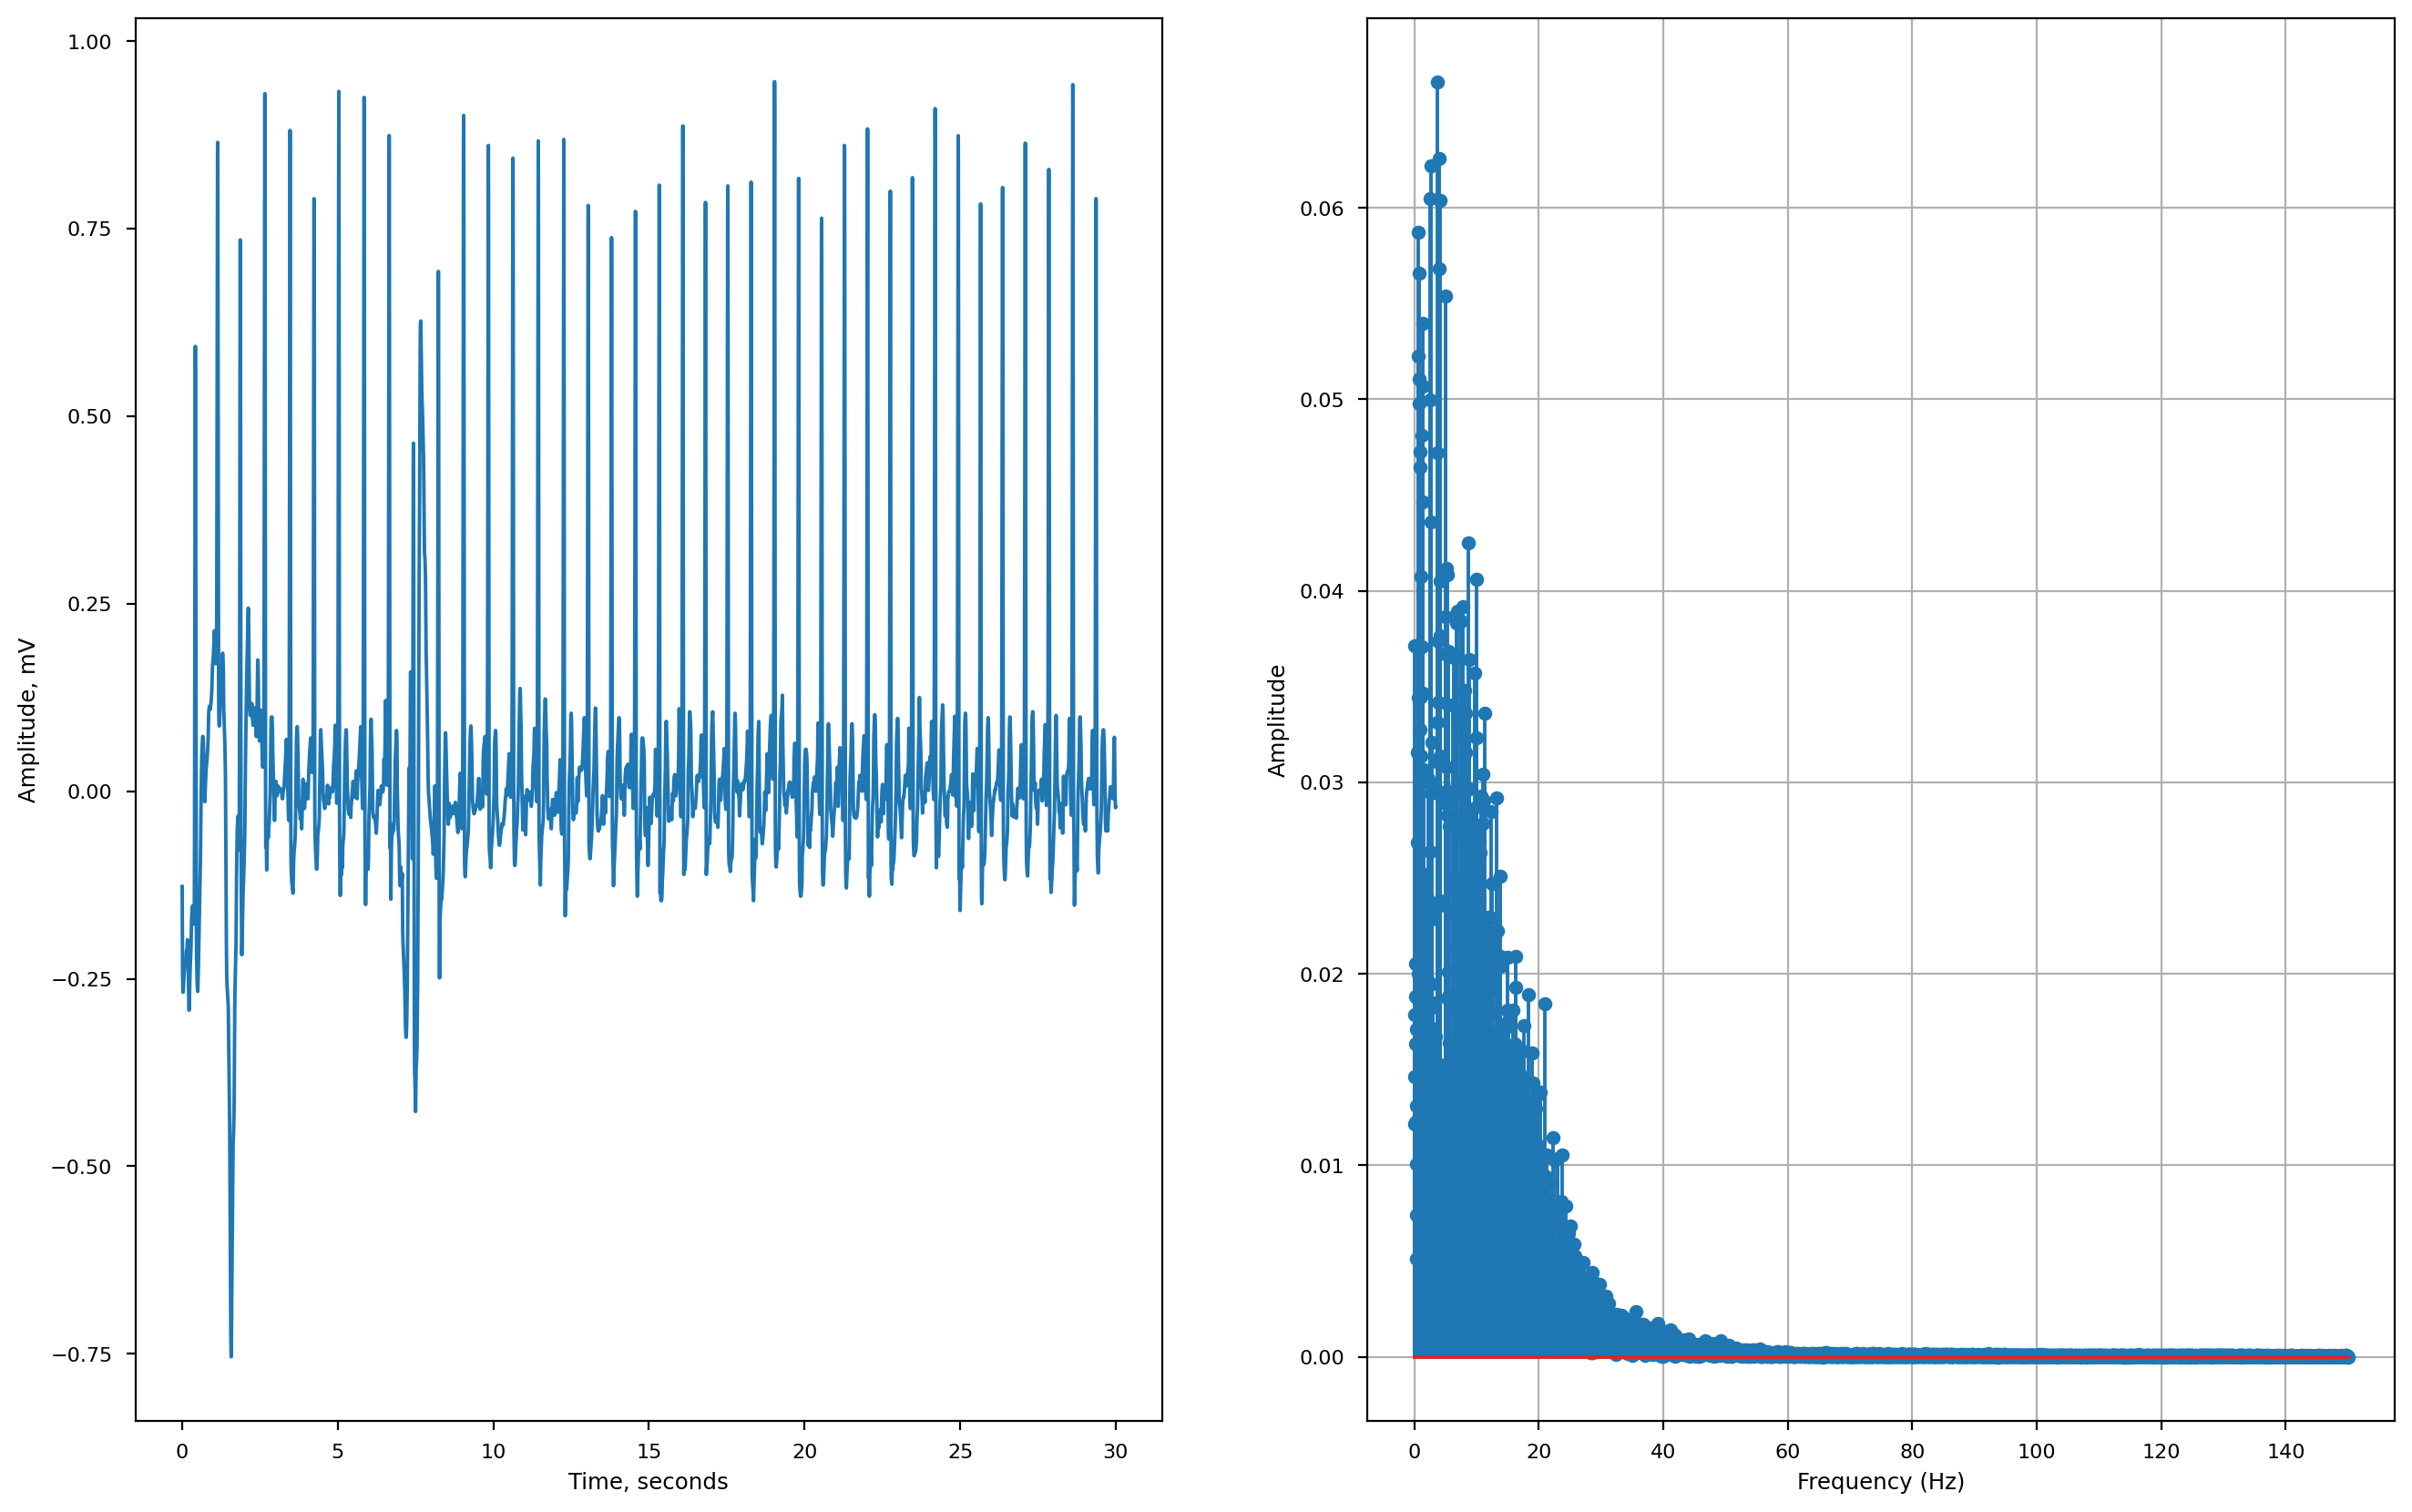

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(np.arange(ecg_signal.shape[0]) / SAMPLING_RATE, ecg_signal / 1000)
# ax[0].plot(np.arange(rec.shape[0]) / SAMPLING_RATE, cleaned / 1000)
ax[0].set_xlabel("Time, seconds")
ax[0].set_ylabel("Amplitude, mV")

fft_result = np.fft.fft(ecg_signal)
fft_freq = np.fft.fftfreq(len(ecg_signal), 1/SAMPLING_RATE)

fft_result = fft_result[:fft_result.shape[0] // 2]
fft_freq = fft_freq[:fft_freq.shape[0] // 2]
fft_result /= fft_result.shape[0]
fft_result[1:] *= 2
fft_magnitude = np.abs(fft_result)

ax[1].stem(fft_freq, fft_magnitude / 1000)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

- no need to filter out the signal additionally, as it is already filtered out

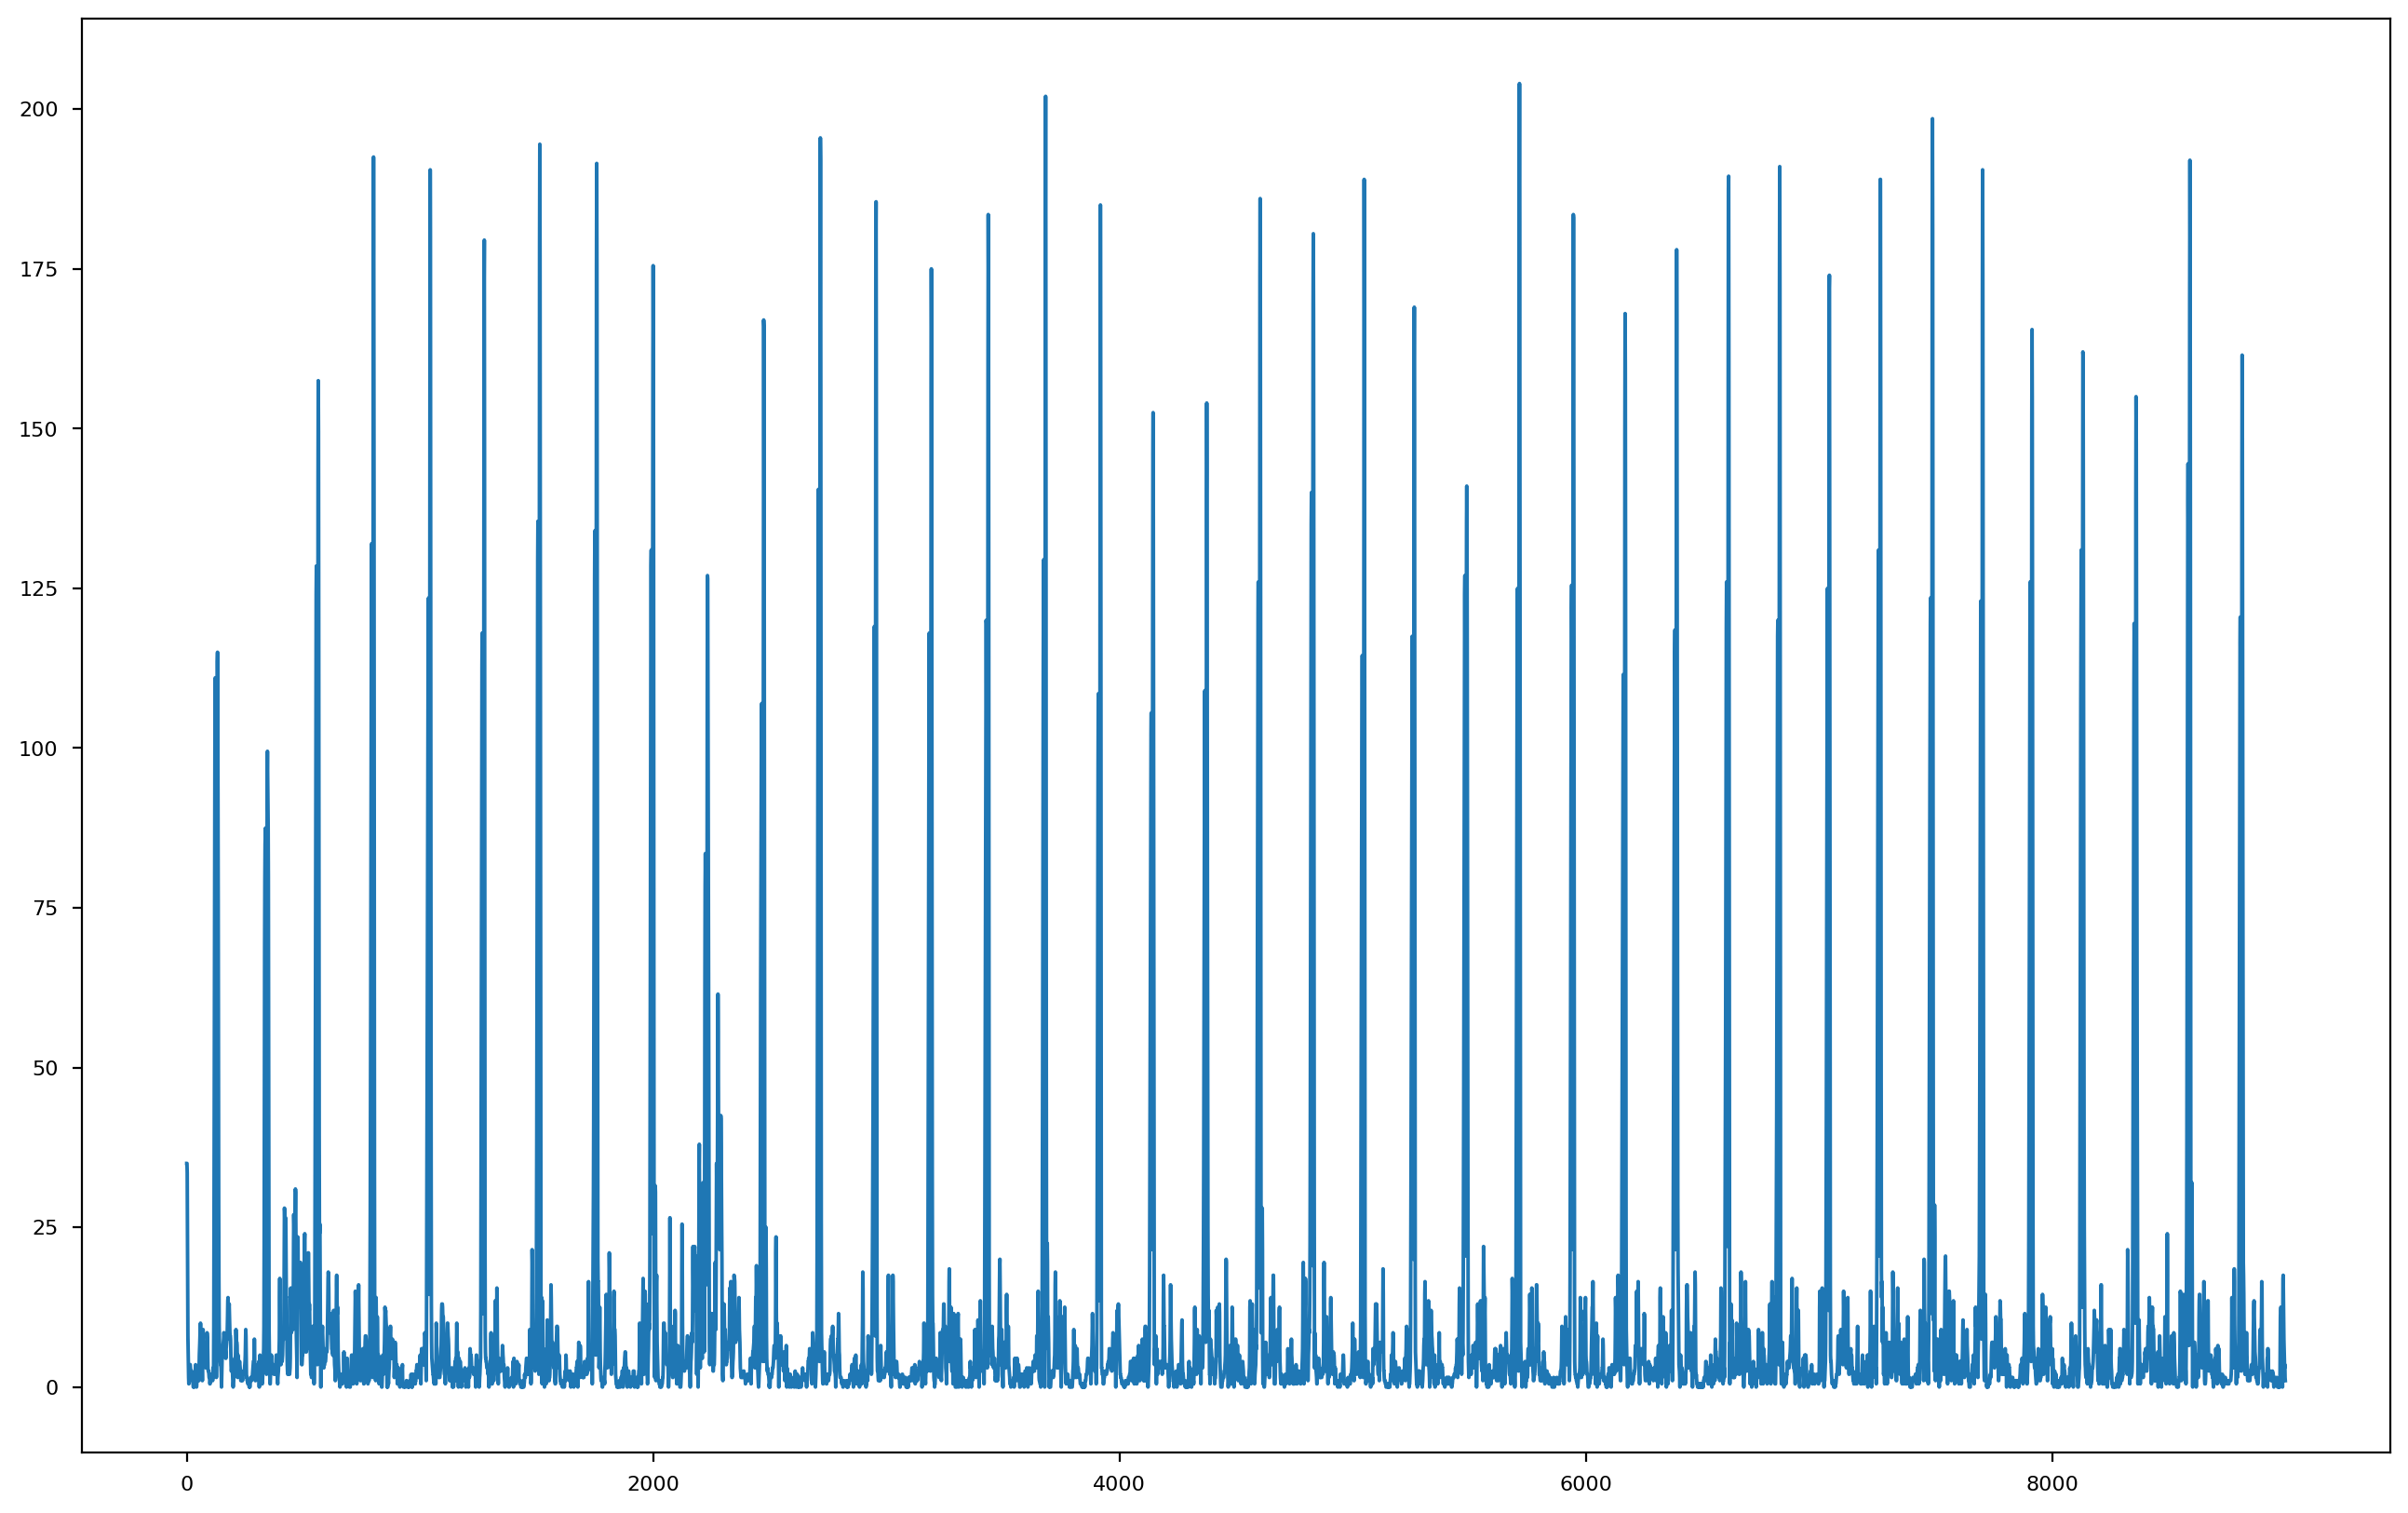

In [7]:
grad = np.gradient(ecg_signal)
abs_grad = np.abs(grad)
plt.plot(abs_grad)

In [8]:
moving_average = lambda signal, window_size: np.convolve(signal, np.ones((window_size,)) / window_size, mode="same")

smoothgrad = moving_average(abs_grad, int(np.rint(0.1 * SAMPLING_RATE)))
avggrad = moving_average(smoothgrad, int(np.rint(0.75 * SAMPLING_RATE)))

In [9]:
qrs = smoothgrad > 1.5 * avggrad

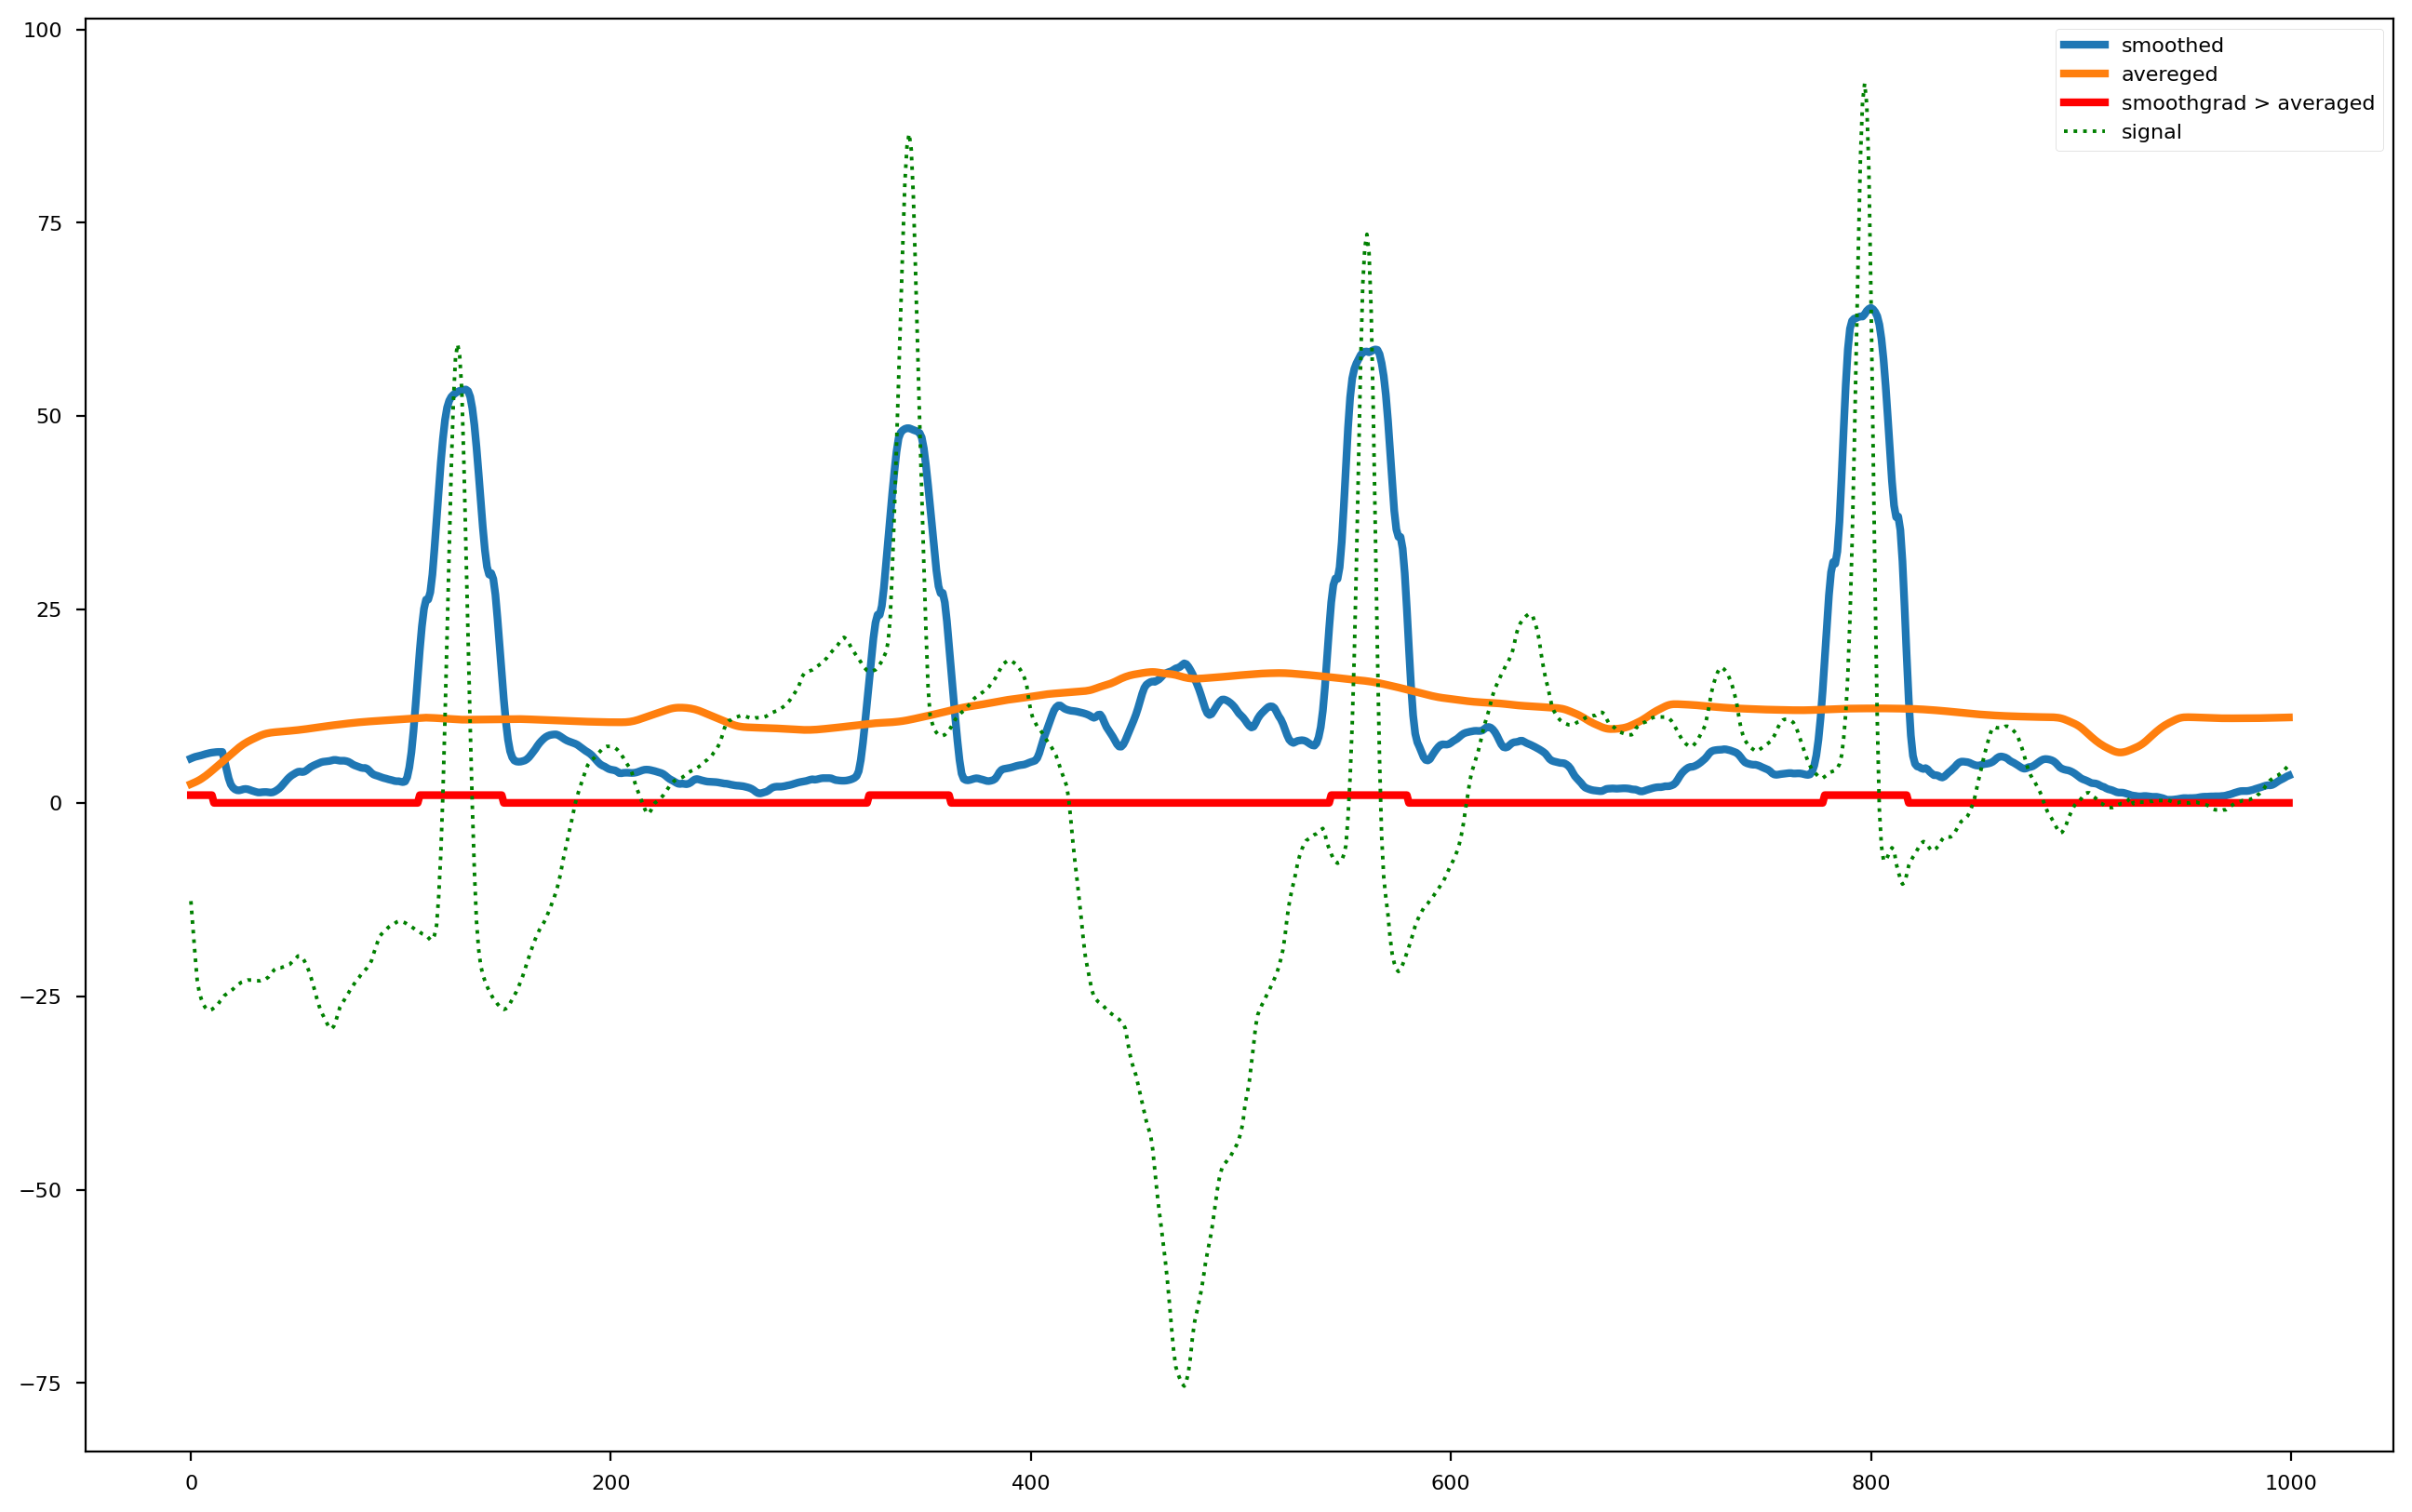

In [10]:
plt.plot(smoothgrad[:1000], label="smoothed", linewidth=3)
plt.plot(avggrad[:1000], label="avereged", linewidth=3)
plt.plot((smoothgrad > 1.5 * avggrad)[:1000], label="smoothgrad > averaged", linewidth=3, c="r")
plt.plot((ecg_signal / 10)[:1000], label="signal", linestyle="dotted", c="g")
plt.legend()